In [22]:
import numpy as np
import pandas as pd
from pandas.core.frame import DataFrame
import math
# from const import *

def sort(a1, a2, a3):  # 从小到大对a1,a2,a3进行排序
    b1 = min(a1, a2, a3)
    b3 = max(a1, a2, a3)
    b2 = a1 + a2 + a3 - b1 - b3
    return b1, b2, b3

# 读取附件数据
node = pd.read_csv('./data/1.csv')  # 主索节点坐标
node.index = node.index + 1
actuator = pd.read_csv('./data/2.csv')  # 促动器上、下端
triangle = pd.read_csv('./data/3.csv')  # 三角形

#输出节点位置xi, yi, zi
id = pd.Series(range(1, 2227, 1), index=node['id'])
id.to_csv('./data/id.csv')
xi = pd.Series(node['x'])
xi.index = xi.index - 1
xi.to_csv('./data/xi.csv', header=False, index=0)

yi = pd.Series(node['y'])
yi.index = yi.index - 1
yi.to_csv('./data/yi.csv', header=False, index=0)

zi = pd.Series(node['z'])
zi.index = zi.index - 1
zi.to_csv('./data/zi.csv', header=False, index=0)

# 链接状况
connected = pd.DataFrame(columns=['node1', 'node2'])
t = 1
for i in triangle.index:
    n1 = id[triangle.loc[i, 'node1']]
    n2 = id[triangle.loc[i, 'node2']]
    n3 = id[triangle.loc[i, 'node3']]
    n1, n2, n3 = sort(n1, n2, n3)
    connected.loc[t] = [n1, n2]
    t = t + 1
    connected.loc[t] = [n1, n3]
    t = t + 1
    connected.loc[t] = [n2, n3]
    t = t + 1

connected.drop_duplicates(
subset=['node1', 'node2'], keep='first', inplace=True)
connected.to_csv('./data/connected.csv', header=False, index=0)

# 获取项链主锁结点边长
length = [([0.0] * 2226) for i in range(2226)]
for i in connected.index:
    n1 = connected.loc[i, 'node1']
    n2 = connected.loc[i, 'node2']
    x1 = node.loc[n1, 'x']
    y1 = node.loc[n1, 'y']
    z1 = node.loc[n1, 'z']
    x2 = node.loc[n2, 'x']
    y2 = node.loc[n2, 'y']
    z2 = node.loc[n2, 'z']
    dist = np.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2 + (z1 - z2) ** 2)
    length[n1 - 1][n2 - 1] = dist
    length[n2 - 1][n1 - 1] = dist
length = pd.DataFrame(length)
length.to_csv('./data/length.csv', header=False, index=0)


在区间内扫描求得抛物面一、抛物面二的方程

In [23]:
def cmp1(p, R, f, l):
    d_min = np.sqrt(2 * p * f)
    d_max1 = np.sqrt(p ** 2 / 4 + f ** 2 + p * f)
    d_max2 = np.sqrt(p ** 2 / 4 + f ** 2 + p *f + l ** 4 / (4 * p**2) - (f*l**2)/p + l**2/2)
    d_1 = d_min - R
    d_2 = d_max1 - R
    d_3 = d_max2 - R
    return abs(min(d_1, d_2, d_3))+abs(max(d_1, d_2, d_3))


def cmp2(p, R, f, l):
    d_min = np.sqrt(2 * p * f)
    d_max1 = np.sqrt(p ** 2 / 4 + f ** 2 + p * f)
    d_max2 = np.sqrt(p ** 2 / 4 + f ** 2 + p *f + l ** 4 / (4 * p**2) - (f*l**2)/p + l**2/2)
    d_1 = d_min - R
    d_2 = d_max1 - R
    d_3 = d_max2 - R
    return max(abs(d_1), abs(d_2), abs(d_3))


def solve(init, R, f, l, type):
    minimum = 10000
    p_ans = 0
    c_ans = 0 
    for p in np.arange(init, 0, 0.0001):
        if(type == 1):
            t = cmp1(p, R, f, l)
        else:
            t = cmp2(p, R, f, l)
        if(t < minimum):
            minimum = t
            p_ans = p
            c_ans = - p ** 2 - 2 * p * f
    return p_ans , c_ans        

R = 300.4
l = 150
f = - (1 - 0.466) * R
init = - 300.4
p,c = solve(init, R, f, l ,2)

In [24]:
#角度
alpha = 36.795 / 180 * np.pi
beta = 78.169 / 180 * np.pi
sa = np.sin(alpha)
ca = np.cos(alpha)
sb = np.sin(beta)
cb = np.cos(beta)

para = pd.DataFrame(columns=['x', 'y', 'z'])

#计算节点沿径向与抛物面交点
for i in node.index:
    x0 = node.loc[i, 'x']
    y0 = node.loc[i, 'y']
    z0 = node.loc[i, 'z']
    a = (sb*(ca*x0 + sa*y0) - cb*z0) ** 2 + (-sa*x0 + ca*y0) ** 2
    b = 2 * p * (cb *(ca * x0 + sa * y0) + sb * z0)
    t1 = (-b + np.sqrt(b ** 2 - 4 * a * c))/(2*a)
    t2 = (-b - np.sqrt(b ** 2 - 4 * a * c))/(2*a)
    if(abs(1 - t1) < abs(1 - t2)):
        t = t1
    else:
        t = t2
    para.loc[i] = [x0 * t , y0 * t , z0 * t]
(para['x']).to_csv('./data/para_xi.csv', header=False, index=0)
(para['y']).to_csv('./data/para_yi.csv', header=False, index=0)
(para['z']).to_csv('./data/para_zi.csv', header=False, index=0)
para.to_csv('./data/para.csv')

#获取300米口径内的主索节点（工作时只有300米口径内的节点需要被调节）
r_max = 300 / 2
l = cb * ca
m = cb * sa
n = sb
inner = pd.DataFrame(columns = ['id', 'x', 'y', 'z']) 
inner_hash = pd.Series(index = range(1,2227,1))
t = 1
for i in node.index:
    x0 = node.loc[i, 'x']
    y0 = node.loc[i, 'y']
    z0 = node.loc[i, 'z']
    d = np.sqrt((y0*n - z0*m)**2 + (z0*l - x0*n)**2 + (x0*m - y0*l)**2)
    if(d <= r_max):
        inner.loc[t] = [i, x0, y0, z0]
        inner_hash[i] = 1
    t = t + 1
(inner['id']).to_csv('./data/inner.csv', header=False, index=0)
inner.to_csv('./data/inner_detail.csv', index=0)
inner_detail = inner.copy()

#获取口径内的点的链接状况
for i in connected.index:
    if(inner_hash[connected.loc[i, 'node1']] != 1 or inner_hash[connected.loc[i, 'node2']] != 1):
        connected.drop(index = i, inplace = True)
connected.to_csv('./data/connected_inner.csv', header=False, index=0)

线性规划求解问题二代码

In [25]:
connected = connected.transpose()
inner = inner['id']
inner = inner.astype(int)

In [26]:
l = length
para_x = para['x']
para_y = para['y']
para_z = para['z']
x = xi
y = yi
z = zi
# connected = pd.read_csv('./data/connected.csv').transpose()
# l = pd.read_csv('./data/length.csv')
# para_x = pd.read_csv('./data/para_xi.csv')['0'].tolist()

# para_y = pd.read_csv('./data/para_yi.csv')['0'].tolist()
# para_z = pd.read_csv('./data/para_zi.csv')['0'].tolist()
# x = pd.read_csv('./data/xi.csv')['0'].tolist()
# y = pd.read_csv('./data/yi.csv')['0'].tolist()
# z = pd.read_csv('./data/zi.csv')['0'].tolist()
# inner = pd.read_csv('./data/inner.csv')

N = 692 #300口径内
M = 2226 #总节点数

bianliang = np.zeros((6*N+3*M,1))
e_cond1 = np.zeros((2*M,6*N+3*M))
b1 = np.zeros((2*M,1))
# for i in range(1,M):
#     e_cond1.iloc[i,i] = y[i]
#     e_cond1.iloc[i,M+i] = -x[i]
#     e_cond1.loc[M+i,M+i] = z[i]
#     e_cond1.iloc[M+i,2*M+i] = -y[i]
# #2M个等式条件 保证比例条件

# in_cond1 = np.zeros(6*M,6*N+3*M)
# in_b1 = np.zeros(6*M,1)
# for i in range(1,M):
#     in_cond1.iloc[i,i] = 1
#     in_cond1.iloc[M+i,i] = -1
#     in_cond1.iloc[2*M+i,M+i] = 1
#     in_cond1.iloc[3*M+i,M+i] = -1
#     in_cond1.iloc[4*M+i,2*M+i] = 1
#     in_cond1.iloc[5*M+i,2*M+i] = -1
#     temp = math.sqrt(x[i]^2 + y[i]^2 + z[i]^2)
#     in_b1.iloc[i,1] = abs(0.6/temp*x[i])
#     in_b1.iloc[M+i,1] = abs(0.6/temp*x[i])
#     in_b1.iloc[2*M+i,1] = abs(0.6/temp*y[i])
#     in_b1.iloc[3*M+i,1] = abs(0.6/temp*y[i])
#     in_b1.iloc[4*M+i,1] = abs(0.6/temp*z[i])
#     in_b1.iloc[5*M+i,1] = abs(0.6/temp*z[i])

# #6M个不等式条件 伸缩范围

B = 1986#边数
# in_cond2 = np.zeros(2*B,6*N+3*M)
# in_b2 = np.zeros(2*B,1)
# for i in range(1,B):
#     a=connected.iloc[1,i]
#     b=connected.iloc[2,i]
#     in_cond2.iloc[i,a] = 2*(x[a-1] - x[b-1])
#     in_cond2.iloc[i,b] = -2*(x[a-1] - x[b-1])
#     in_cond2.iloc[i,M+a] = 2*(y[a-1] - y[b-1])
#     in_cond2.iloc[i,M+b] = -2*(y[a-1] - y[b-1])
#     in_cond2.iloc[i,2*M+a] = 2*(z(a-1) - z(b-1))
#     in_cond2.iloc[i,2*M+b] = -2*(z(a-1) - z(b-1))
#     in_cond2.iloc[B+i,a] = -2*(x(a-1) - x(b))
#     in_cond2.iloc[B+i,b] = 2*(x(a) - x(b))
#     in_cond2.iloc[B+i,M+a] = -2*(y(a) - y(b))
#     in_cond2.iloc[B+i,M+b] = 2*(y(a) - y(b))
#     in_cond2.iloc[B+i,2*M+a] = -2*(z(a) - z(b));
# in_cond2(B+i,2*M+b) = 2*(z(a) - z(b));
# in_b2(i,1) = 0.001047*l(a,b)^2;
# in_b2(B+i,1) = (0.0014-0.0007^2)*l(a,b)^2;
# end
# %2B个不等式条件 边长偏移量


from scipy.optimize import linprog



# 构建等式条件 e_cond1
for i in range(1, M+1):
    e_cond1[i-1, i-1] = y[i-1]
    e_cond1[i-1, M+i-1] = -x[i-1]
    e_cond1[M+i-1, M+i-1] = z[i-1]
    e_cond1[M+i-1, 2*M+i-1] = -y[i-1]



# 初始化变量
in_cond1 = np.zeros((6*M, 6*N+3*M))
in_b1 = np.zeros((6*M, 1))

# 构建伸缩范围条件 in_cond1
for i in range(1, M+1):
    in_cond1[i-1, i-1] = 1
    in_cond1[M+i-1, i-1] = -1
    in_cond1[2*M+i-1, M+i-1] = 1
    in_cond1[3*M+i-1, M+i-1] = -1
    in_cond1[4*M+i-1, 2*M+i-1] = 1
    in_cond1[5*M+i-1, 2*M+i-1] = -1

# 构建伸缩范围条件 in_b1
for i in range(1, M+1):
    temp = np.sqrt(x[i-1]**2 + y[i-1]**2 + z[i-1]**2)
    in_b1[i-1, 0] = np.abs(0.6/temp*x[i-1])
    in_b1[M+i-1, 0] = np.abs(0.6/temp*x[i-1])
    in_b1[2*M+i-1, 0] = np.abs(0.6/temp*y[i-1])
    in_b1[3*M+i-1, 0] = np.abs(0.6/temp*y[i-1])
    in_b1[4*M+i-1, 0] = np.abs(0.6/temp*z[i-1])
    in_b1[5*M+i-1, 0] = np.abs(0.6/temp*z[i-1])

# 初始化变量
in_cond2 = np.zeros((2*B, 6*N+3*M))
in_b2 = np.zeros((2*B, 1))

# 构建边长偏移量条件 in_cond2
for i in range(1, B+1):
    a = connected.iloc[0, i-1]
    b = connected.iloc[1, i-1]
    in_cond2[i-1, a-1] = 2 * (x[a-1] - x[b-1])
    in_cond2[i-1, b-1] = -2 * (x[a-1] - x[b-1])
    in_cond2[i-1, M+a-1] = 2 * (y[a-1] - y[b-1])
    in_cond2[i-1, M+b-1] = -2 * (y[a-1] - y[b-1])
    in_cond2[i-1, 2*M+a-1] = 2 * (z[a-1] - z[b-1])
    in_cond2[i-1, 2*M+b-1] = -2 * (z[a-1] - z[b-1])
    in_cond2[B+i-1, a-1] = -2 * (x[a-1] - x[b-1])
    in_cond2[B+i-1, b-1] = 2 * (x[a-1] - x[b-1])
    in_cond2[B+i-1, M+a-1] = -2 * (y[a-1] - y[b-1])
    in_cond2[B+i-1, M+b-1] = 2 * (y[a-1] - y[b-1])
    in_cond2[B+i-1, 2*M+a-1] = -2 * (z[a-1] - z[b-1])
    in_cond2[B+i-1, 2*M+b-1] = 2 * (z[a-1] - z[b-1])
    in_b2[i-1, 0] = 0.001047 * l.iloc[a-1, b-1]**2
    in_b2[B+i-1, 0] = (0.0014 - 0.0007**2) * l.iloc[a-1, b-1]**2




from scipy.optimize import linprog



# 初始化变量
e_cond2 = np.zeros((3*N, 6*N+3*M))
b2 = np.zeros((3*N, 1))


# 循环构建矩阵 e_cond2 和向量 b2
for i in range(1, N+1):
    e_cond2[i-1, inner.iloc[i-1]-1] = 1
    e_cond2[i-1, 3*M+i-1] = -1
    e_cond2[i-1, 3*M+N+i-1] = 1
    e_cond2[N+i-1, M+inner.iloc[i-1]-1] = 1
    e_cond2[N+i-1, 3*M+2*N+i-1] = -1
    e_cond2[N+i-1, 3*M+3*N+i-1] = 1
    e_cond2[2*N+i-1, 2*M+inner.iloc[i-1]-1] = 1
    e_cond2[2*N+i-1, 3*M+4*N+i-1] = -1
    e_cond2[2*N+i-1, 3*M+5*N+i-1] = 1
    b2[i-1] = para_x[inner.iloc[i-1]] - x[inner.iloc[i-1]-1]
    b2[N+i-1] = para_y[inner.iloc[i-1]] - y[inner.iloc[i-1]-1]
    b2[2*N+i-1] = para_z[inner.iloc[i-1]] - z[inner.iloc[i-1]-1]

# 构建线性规划的 A, b, Aeq, beq, f
in_cond3 = np.hstack([np.zeros((6*N,3*M)), -np.eye((6*N))])
in_b3 = np.zeros((6*N, 1))

A = np.vstack([in_cond1, in_cond2, in_cond3])
b = np.vstack([in_b1, in_b2, in_b3])
Aeq = np.vstack([e_cond1, e_cond2])
beq = np.vstack([b1, b2])
f = np.vstack([np.zeros((3*M, 1)), np.ones((6*N, 1))])

# 调用线性规划求解器
result = linprog(c=f, A_ub=A, b_ub=b, A_eq=Aeq, b_eq=beq,method='highs')

# 输出结果
deci = result.x
fval = result.fun

print("Decision variables:", deci)
print("Optimal value:", fval)



# e_cond2 = zeros(3*N,6*N+3*M);
# b2 = zeros(3*N,1);
# for i = 1:N
# e_cond2(i,inner(i)) = 1;
# e_cond2(i,3*M+i) = -1;
# e_cond2(i,3*M+N+i) = 1;
# e_cond2(N+i,M+inner(i)) = 1;
# e_cond2(N+i,3*M+2*N+i) = -1;
# e_cond2(N+i,3*M+3*N+i) = 1;
# e_cond2(2*N+i,2*M+inner(i)) = 1;
# e_cond2(2*N+i,3*M+4*N+i) = -1;
# e_cond2(2*N+i,3*M+5*N+i) = 1;
# b2(i) = para_x(inner(i))-x(inner(i));
# b2(N+i) = para_y(inner(i))-y(inner(i));
# b2(2*N+i) = para_z(inner(i))-z(inner(i));
# end
# %3N个等式条件 为计算近似距离绝对值之和而设的alpha、beta

# in_cond3 = [zeros(6*N,3*M) -eye(6*N,6*N)];
# in_b3 = zeros(6*N,1);
# %6N alpha、beta为正

# A = [in_cond1;in_cond2;in_cond3];
# b = [in_b1;in_b2;in_b3];
# Aeq = [e_cond1;e_cond2];
# beq = [b1;b2];
# f = [zeros(3*M,1);ones(6*N,1)];
# [deci,fval] = linprog(f,A,b,Aeq,beq);

Decision variables: [0. 0. 0. ... 0. 0. 0.]
Optimal value: 149.57150007987474


In [27]:
node_2 = pd.DataFrame(inner_detail['id'])
node_2['x'] = inner_detail['x'] + deci[:M][inner_detail['id'].astype(int)]
node_2['y'] = inner_detail['y'] + deci[M:2*M][inner_detail['id'].astype(int)]
node_2['z'] = inner_detail['z'] + deci[M:3*M][inner_detail['id'].astype(int)]

In [28]:
node.set_index(['id'], inplace=True)
inner = inner.tolist()

In [29]:
connected = connected.transpose()

In [31]:
id = pd.read_csv('./data/id.csv')  # 存储主索节点编号与序号的对应关系
id.set_index(["id"], inplace=True)
di = pd.read_csv('./data/id.csv')  # 存储主索节点编号与序号的对应关系
di.set_index(["0"], inplace=True)

下一部分是逐步调整法Python代码

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#from const import *

def dist(x1, x2, y1, y2, z1, z2):
    return np.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2 + (z1 - z2) ** 2)

#node = pd.read_csv('./data/node_origin.csv')


#para = pd.read_csv('./data/para.csv', index_col=0)

#connected = pd.read_csv('./data/connected.csv', header = None)
#connected.columns = ['node1', 'node2']

#inner = pd.read_csv('./data/inner.csv', header=None)
#inner.columns = ['node']

#inner = [round(i) for i in inner]

inner_hash = pd.Series(index=range(1, 2227, 1))
for i in inner:
    inner_hash[i] = 1

length = pd.read_csv('./data/length.csv', header = None)
length.columns = [i for i in range(1, 2227, 1)]
length.index = length.index + 1

connected_list = [[] for i in range(2228)]
for i in connected.index:
    n1 = connected.loc[i, 'node1']
    n2 = connected.loc[i, 'node2']
    connected_list[n1].append(n2)
    connected_list[n2].append(n1)

node_status = [1 for i in range(2227)]

epsilon = 0.005
M = 100000
alpha = 1/2
k = 4
max_dist = 0
for i in range(M):
    max_dist = -1
    max_node = 0
    for _node in inner:
        #挑选出当前距离抛物线的最远点
        if(node_status[_node] == 0):
            continue
        d = dist(node['x'][di['id'][_node]], para['x'].iloc[_node], node['y'][di['id'][_node]], para['y'].iloc[_node],node['z'][di['id'][_node]], para['z'].iloc[_node])
        if(d > max_dist):
            max_dist = d
            max_node = _node
    if(max_dist <= epsilon):
        break
    #print(max_dist, max_node)
    #移动
    
    x0 = node.loc[di['id'][max_node], 'x']
    y0 = node.loc[di['id'][max_node], 'y']
    z0 = node.loc[di['id'][max_node], 'z']
    t_lim = max_dist / np.sqrt(x0 ** 2 + y0 ** 2 + z0 ** 2) / k
    node_to_O = dist(x0, 0, y0, 0, z0, 0)
    para_to_O = dist(para.loc[max_node, 'x'], 0, para.loc[max_node, 'y'], 0, para.loc[max_node, 'z'], 0)
    if(node_to_O > para_to_O): #点在抛物线外
        step = -0.01 / np.sqrt(x0 ** 2 + y0 ** 2 + z0 ** 2) 
        init = 1
        end = 1 - t_lim + step
        #print('wai')
    else:
        step = 0.01 / np.sqrt(x0 ** 2 + y0 ** 2 + z0 ** 2) 
        init = 1
        end = 1 + t_lim + step
        #print('nei')
    #扫描
    t_final = 0
    #d_origin = length.loc[_node, max_node]
    
    # lim_list = pd.Series([])
    # for _node in connected_list[max_node]:
    #     d_origin = length.loc[_node, max_node]
    #     d_now = dist(node.loc[_node, 'x'], x0, node.loc[_node, 'y'], y0,node.loc[_node, 'z'], z0)
    #     e = abs(d_origin - d_now) / d_origin
    #     lim_list[_node] = e + (0.0007 - e) * alpha
    for t in np.arange(init, end, step):
        xt = t * x0
        yt = t * y0
        zt = t * z0
        f = 1
        for _node in connected_list[max_node]:
            if(inner_hash[_node] != 1):
                continue
            d_origin = length.loc[_node, max_node]
            d_new = dist(node['x'][di['id'][_node]], xt, node['y'][di['id'][_node]], yt,node['z'][di['id'][_node]], zt)
            #print(d_origin, d_new)
            if(abs(d_origin - d_new) / d_origin > 0.0007):
                f = 0
                break
        if(f == 0):
            node_status[max_node] = 0
            break
        else:
            node_status[max_node] = 1
            t_final = t

    #print(t_final)
    node.loc[max_node,'x'] = t_final * x0
    node.loc[max_node,'y'] = t_final * y0
    node.loc[max_node,'z'] = t_final * z0
    if(t_final != 1):
        for _node in connected_list[max_node]:
            node_status[_node] = 1
    print(i/100000)

print("last adjust", max_dist)
dmax = -1
d_list = []
for i in inner:
    d = dist(node['x'][i], para.loc[i, 'x'], node['y'][i], para.loc[i, 'y'],node['z'][i], para.loc[i, 'z'])
    d_list.append(d)
    if(d > dmax):
        dmax = d
plt.plot(inner, d_list)
plt.show()
print("dmax" , dmax)

inner_node = pd.DataFrame(columns=['x', 'y', 'z'])
for i in node.index:
    if(inner_hash[i] == 1):
        inner_node.loc[i] = [node.loc[i,'x'],node.loc[i,'y'],node.loc[i,'z']]
inner_node.to_csv('./q3new.csv')

0.0
1e-05
2e-05
3e-05
4e-05
5e-05
6e-05
7e-05
8e-05
9e-05
0.0001
0.00011
0.00012
0.00013
0.00014
0.00015
0.00016
0.00017
0.00018
0.00019
0.0002
0.00021
0.00022
0.00023
0.00024
0.00025
0.00026
0.00027
0.00028
0.00029
0.0003
0.00031
0.00032
0.00033
0.00034
0.00035
0.00036
0.00037
0.00038
0.00039
0.0004
0.00041
0.00042
0.00043
0.00044
0.00045
0.00046
0.00047
0.00048
0.00049
0.0005
0.00051
0.00052
0.00053
0.00054
0.00055
0.00056
0.00057
0.00058
0.00059
0.0006
0.00061
0.00062
0.00063
0.00064
0.00065
0.00066
0.00067
0.00068
0.00069
0.0007
0.00071
0.00072
0.00073
0.00074
0.00075
0.00076
0.00077
0.00078
0.00079
0.0008
0.00081
0.00082
0.00083
0.00084
0.00085
0.00086
0.00087
0.00088
0.00089
0.0009
0.00091
0.00092
0.00093
0.00094
0.00095
0.00096
0.00097
0.00098
0.00099
0.001
0.00101
0.00102
0.00103
0.00104
0.00105
0.00106
0.00107
0.00108
0.00109
0.0011
0.00111
0.00112
0.00113
0.00114
0.00115
0.00116
0.00117
0.00118
0.00119
0.0012
0.00121
0.00122
0.00123
0.00124
0.00125
0.00126
0.00127
0.00128
0.0

求反射比代码

42.1255572469134


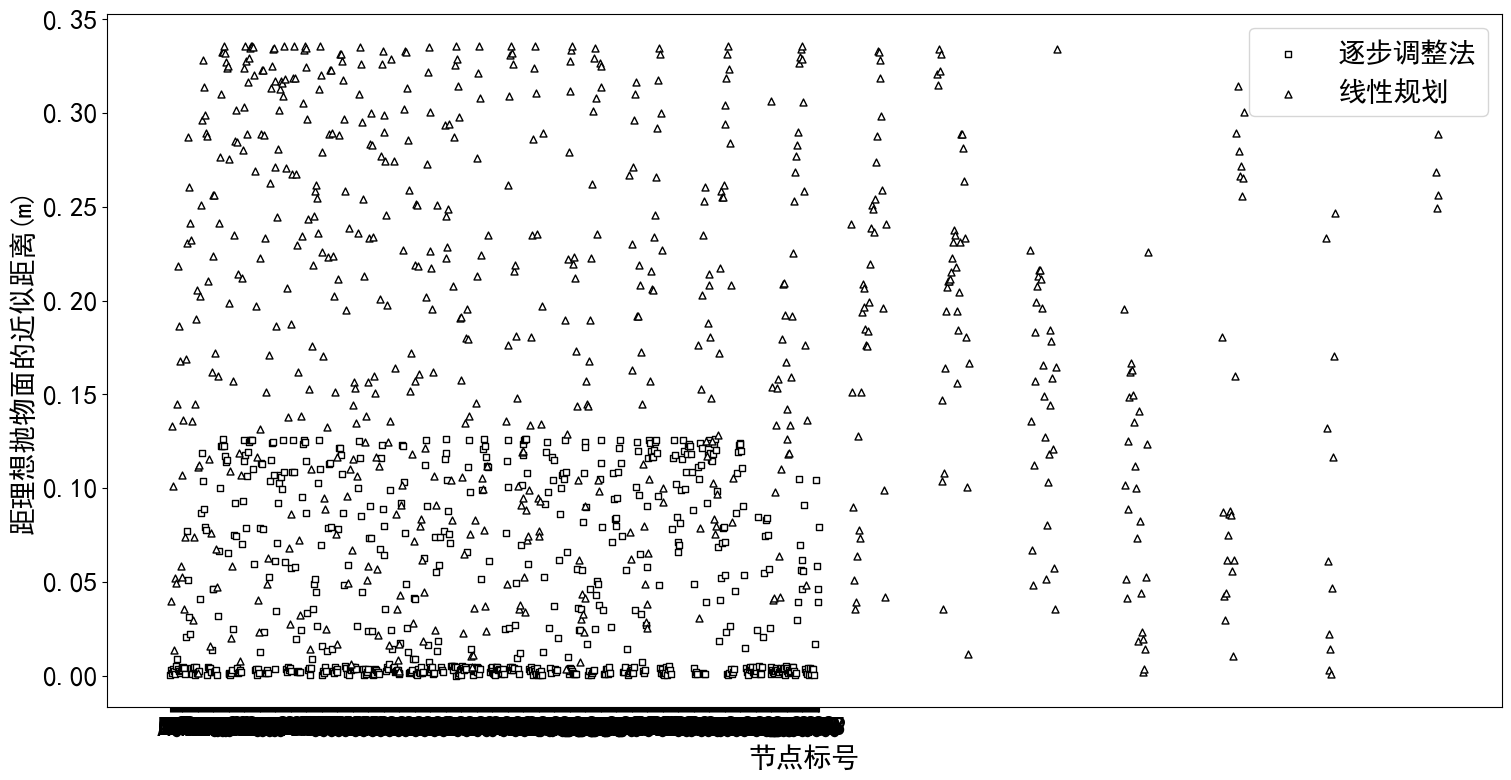

dmax 0.33598272485821373


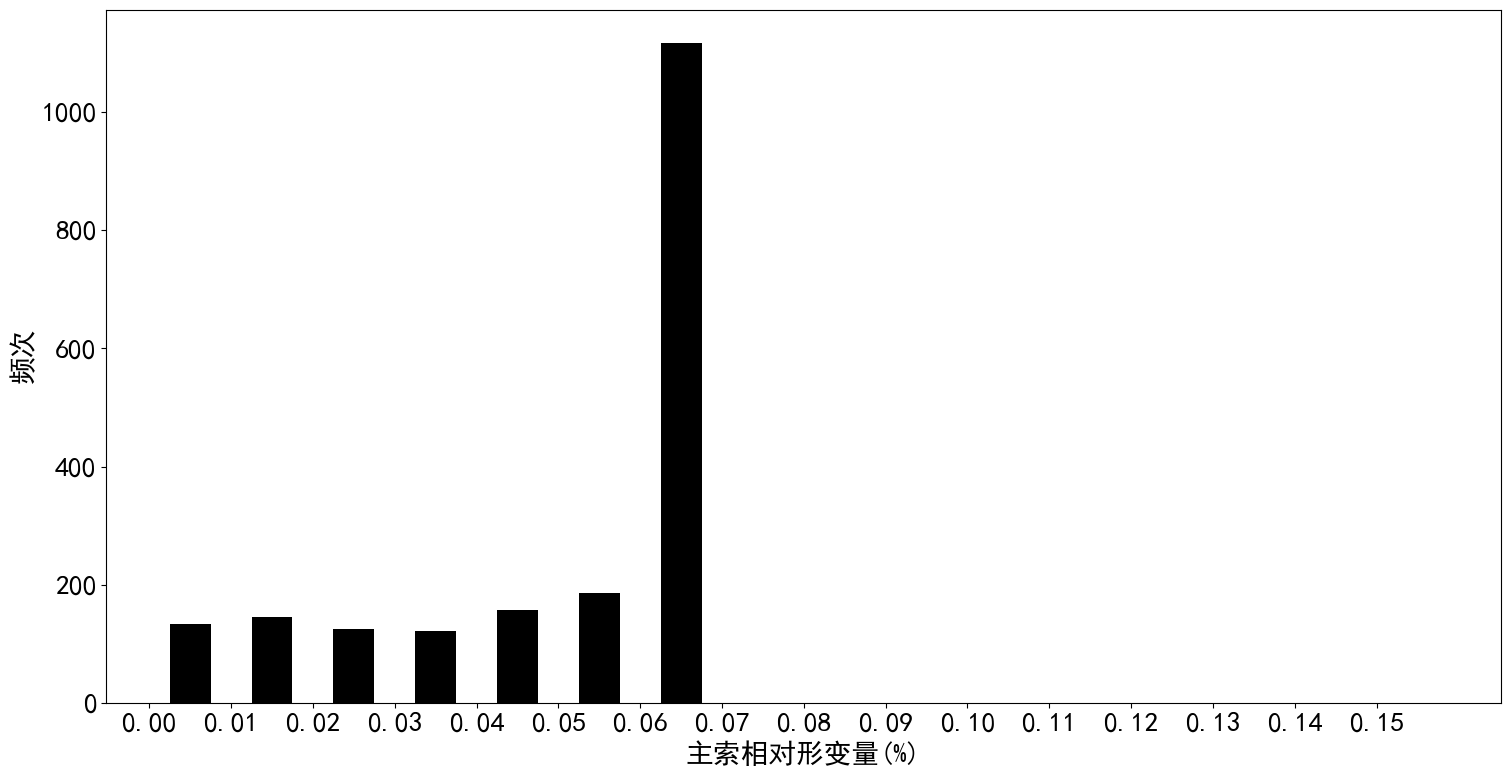

0.0006996751283310176
238 239 12.135810169082244 12.144301293619698
723 66601
0.010855692857464603
S: 66618.42289476842
0.015267407684002202


In [ ]:
import pandas as pd
import numpy as np
#from const import *
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

#para = pd.read_csv('./data/data/para.csv', index_col=0)

node_origin = pd.read_csv('./data/1.csv')  # 原始点坐标
node_origin.set_index(["id"], inplace=True)

node = pd.read_csv('./data/res.csv')  # 300米口径内的点调整后的点
#node_2 = pd.read_csv('./4_141047.csv')
'''
    result文件格式为三列，分别是id(点序号), x, y, z
'''
node = node.iloc[:,:4]
node.columns = ['id', 'x', 'y', 'z']
node.set_index(["id"], inplace=True)

node_2.columns = ['id', 'x', 'y', 'z']
node_2.set_index(["id"], inplace=True)

connected = pd.read_csv('./data/data/connected.csv', header=None)
connected.columns = ['node1', 'node2']

triangle = pd.read_csv('./data/3.csv')  # 三角形
id = pd.read_csv('./data/id.csv')  # 存储主索节点编号与序号的对应关系
id.set_index(["id"], inplace=True)
di = pd.read_csv('./data/id.csv')  # 存储主索节点编号与序号的对应关系
di.set_index(["0"], inplace=True)


def norm_vec(x1, x2, x3, y1, y2, y3, z1, z2, z3):
    a1 = x2 - x1
    a2 = y2 - y1
    a3 = z2 - z1
    b1 = x3 - x1
    b2 = y3 - y1
    b3 = z3 - z1
    A = a2 * b3 - a3 * b2
    B = a3 * b1 - a1 * b3
    C = a1 * b2 - a2 * b1
    return A, B, C


def reflect(A, B, C, x0, y0, z0, z_f):
    x_ref = x0 - 2 * A * C * (z_f - z0) / (A ** 2 + B ** 2 - C ** 2)
    y_ref = y0 - 2 * B * C * (z_f - z0) / (A ** 2 + B ** 2 - C ** 2)
    return x_ref, y_ref


def S_tri(x1, y1, x2, y2, x3, y3):  # 根据三点坐标计算平面三角形面积
    S = abs(x1 * y2 - x1 * y3 + x2 * y3 - x2 * y1 + x3 * y1 - x3 * y2) / 2
    return S


def dist(x1, x2, y1, y2, z1, z2):
    return np.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2 + (z1 - z2) ** 2)


sum = 0
for i in node.index:
    sum = sum + abs(node.loc[i, 'x'] - para.loc[id['0'][i], 'x']) + abs(
        node.loc[i, 'y'] - para.loc[id['0'][i], 'y']) + abs(node.loc[i, 'z'] - para.loc[id['0'][i], 'z'])
print(sum)

dmax = -1
d_list1 = []
d_list2 = []

for i in node.index:
    d = dist(node.loc[i, 'x'], para.loc[id['0'][i], 'x'], node.loc[i, 'y'],
             para.loc[id['0'][i], 'y'], node.loc[i, 'z'], para.loc[id['0'][i], 'z'])
    d_list1.append(d)
    if (d > dmax):
        dmax = d

for i in node.index:
    d = dist(node_2.loc[id['0'][i], 'x'], para.loc[id['0'][i], 'x'], node_2.loc[id['0'][i], 'y'],
             para.loc[id['0'][i], 'y'], node_2.loc[id['0'][i], 'z'], para.loc[id['0'][i], 'z'])
    d_list2.append(d)
    if (d > dmax):
        dmax = d
plt.figure(figsize=(18, 9))
plt.ylabel('距理想抛物面的近似距离(m)', fontsize=20)
plt.xlabel('节点标号', fontsize=20)
plt.scatter(node.index, d_list1, c='w', s=25, marker='s', edgecolors='k', label=u'逐步调整法')
plt.scatter(node_2.index, d_list2, c='w', s=25,
            marker='^', edgecolors='k', label=u'线性规划')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)
plt.show()
print("dmax", dmax)

#fig = plt.figure()
#ax = fig.gca(projection='3d')
inner_hash = pd.Series(index=range(1, 2227, 1))
for i in node.index:
    x0 = node.loc[i, 'x']
    y0 = node.loc[i, 'y']
    z0 = node.loc[i, 'z']
    #type1 = ax.scatter(x0,y0,z0,c='w',s=25,marker = 's',edgecolors='c')
    x_rotate = sb * (ca * x0 + sa * y0) - cb * z0
    y_rotate = -sa * x0 + ca * y0
    z_rotate = cb * (ca * x0 + sa * y0) + sb * z0
    #type2 = ax.scatter(x_rotate,y_rotate,z_rotate,c='w',s=25,marker = '^',edgecolors='k')
    node.loc[i, 'x'] = x_rotate
    node.loc[i, 'y'] = y_rotate
    node.loc[i, 'z'] = z_rotate
    inner_hash[id['0'][i]] = 1
#ax.legend((type1, type2), (u'旋转前主索节点', u'旋转后主索节点'))
# plt.show()

k = 1  # 单位面积取点数量
all_wave = 0
receive_wave = 0
triangle_num = 0
area = 0
tri_ref = pd.DataFrame(columns=['x1', 'y1', 'x2', 'y2', 'x3', 'y3', 'cos'])
for i in triangle.index:
    n1 = id.loc[triangle.loc[i, 'node1'], '0']
    n2 = id.loc[triangle.loc[i, 'node2'], '0']
    n3 = id.loc[triangle.loc[i, 'node3'], '0']
    if(inner_hash[n1] != 1 or inner_hash[n2] != 1 or inner_hash[n3] != 1):
          # 判断三角形三个结点是否全在口径内
        continue
    x1 = node.loc[di['id'][n1], 'x']
    y1 = node.loc[di['id'][n1], 'y']
    z1 = node.loc[di['id'][n1], 'z']
    x2 = node.loc[di['id'][n2], 'x']
    y2 = node.loc[di['id'][n2], 'y']
    z2 = node.loc[di['id'][n2], 'z']
    x3 = node.loc[di['id'][n3], 'x']
    y3 = node.loc[di['id'][n3], 'y']
    z3 = node.loc[di['id'][n3], 'z']

    S = S_tri(x1, y1, x2, y2, x3, y3)
    num = round(S * k)  # 随机取点的数量

    all_wave = all_wave + num
    # 生成随机点
    rnd1 = np.random.random(size=num)
    rnd2 = np.random.random(size=num)
    rnd2 = np.sqrt(rnd2)
    x_list = rnd2 * (rnd1 * x1 + (1 - rnd1) * x2) + (1 - rnd2) * x3
    y_list = rnd2 * (rnd1 * y1 + (1 - rnd1) * y2) + (1 - rnd2) * y3
    z_list = rnd2 * (rnd1 * z1 + (1 - rnd1) * z2) + (1 - rnd2) * z3

    # 求平面法向量
    A, B, C = norm_vec(x1, x2, x3, y1, y2, y3, z1, z2, z3)
    z_f = -0.534 * R  # 旋转后焦点纵坐标
    x1_ref = x1 - 2 * A * C * (z_f - z1) / (A ** 2 + B ** 2 - C ** 2)
    y1_ref = y1 - 2 * B * C * (z_f - z1) / (A ** 2 + B ** 2 - C ** 2)
    x2_ref = x2 - 2 * A * C * (z_f - z2) / (A ** 2 + B ** 2 - C ** 2)
    y2_ref = y2 - 2 * B * C * (z_f - z2) / (A ** 2 + B ** 2 - C ** 2)
    x3_ref = x3 - 2 * A * C * (z_f - z3) / (A ** 2 + B ** 2 - C ** 2)
    y3_ref = y3 - 2 * B * C * (z_f - z3) / (A ** 2 + B ** 2 - C ** 2)
    cos_theta = (C**2 - A**2 - B**2) / np.sqrt((2*A*C)
                                               ** 2 + (2*B*C)**2 + (C**2-A**2-B**2)**2)
    tri_ref.loc[i] = [x1_ref, y1_ref, x2_ref,y2_ref, x3_ref, y3_ref, abs(cos_theta)]

    for i in range(num):
        x0 = x_list[i]
        y0 = y_list[i]
        z0 = z_list[i]
        x_ref = x0 - 2 * A * C * (z_f - z0) / (A ** 2 + B ** 2 - C ** 2)
        y_ref = y0 - 2 * B * C * (z_f - z0) / (A ** 2 + B ** 2 - C ** 2)
        d = np.sqrt(x_ref ** 2 + y_ref ** 2)
        # print(d)
        if(d <= 0.5):
            receive_wave = receive_wave + 1

    # 求上限
    triangle_num = triangle_num + 1
    area = area + S
tri_ref.to_csv('./tri_ref.csv', index=0)
# 验证边长变化量
upper = 16
e_x = [i for i in range(0, upper, 1)]
e_height = [0 for i in np.arange(0, upper * 0.0001, 0.0001)]
maxe = -1
a = 0
b = 0
c = 0
d = 0
for i in connected.index:
    n1 = connected.loc[i, 'node1']
    n2 = connected.loc[i, 'node2']
    #print(n1, n2)
    if(inner_hash[n1] != 1 or inner_hash[n2] != 1):
        continue
    length_origin = dist(node_origin.loc[di['id'][n1], 'x'], node_origin.loc[di['id'][n2], 'x'], node_origin.loc[di['id'][n1], 'y'],node_origin.loc[di['id'][n2], 'y'], node_origin.loc[di['id'][n1], 'z'], node_origin.loc[di['id'][n2], 'z'])
    length_new = dist(node.loc[di['id'][n1], 'x'], node.loc[di['id'][n2], 'x'], node.loc[di['id'][n1], 'y'],node.loc[di['id'][n2], 'y'], node.loc[di['id'][n1], 'z'], node.loc[di['id'][n2], 'z'])
    e = abs(length_new - length_origin) / length_origin
    if(e > maxe):
        maxe = e
        a = n1
        b = n2
        c = length_origin
        d = length_new
    for j in e_x:
        if((e >= j * 0.0001 and e < j * 0.0001 + 0.0001) or (j == upper - 0.0001)):
            e_height[j] = e_height[j] + 1
            break

plt.figure(figsize=(18, 9))
plt.bar([x * 0.01 + 0.005 for x in e_x], e_height, width=0.005, color='k')
plt.xticks([x * 0.01 for x in e_x], fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('主索相对形变量(%)', fontsize=20)
plt.ylabel('频次', fontsize=20)
plt.show()
print(maxe)
print(a, b, c, d)
print(receive_wave, all_wave)
print(receive_wave / all_wave)
print('S:', area)
print(triangle_num * np.pi * 0.5 * 0.5 / area)  # 接收比上限